In [1]:
import numpy as np

def qam_modulate(bits, M):
    """QAM Modulation: M = 4, 16, 64, 256"""
    k = int(np.log2(M))
    symbols = np.reshape(bits, (-1, k))
    decimal = symbols.dot(1 << np.arange(symbols.shape[-1] - 1, -1, -1))
    return np.sqrt(1/M) * (2*(decimal % np.sqrt(M)) - np.sqrt(M) + 1 + 1j*(2*(decimal // np.sqrt(M)) - np.sqrt(M) + 1))

# OFDM Parameters
N_subcarriers = 64
CP_len = 16
num_ofdm_symbols = 10
M = 16  # 16-QAM

# Generate random data and QAM modulate
bits = np.random.randint(0, 2, N_subcarriers * num_ofdm_symbols * int(np.log2(M)))
qam_syms = qam_modulate(bits, M)

# OFDM modulation
ofdm_syms = np.reshape(qam_syms, (num_ofdm_symbols, N_subcarriers))
ifft_data = np.fft.ifft(ofdm_syms, axis=1)
ofdm_signal = np.hstack([np.concatenate([sym[-CP_len:], sym]) for sym in ifft_data])

# Add AWGN noise
snr_db = 20
snr_linear = 10**(snr_db/10)
signal_power = np.mean(np.abs(ofdm_signal)**2)
noise_power = signal_power / snr_linear
noise = np.sqrt(noise_power/2) * (np.random.randn(*ofdm_signal.shape) + 1j*np.random.randn(*ofdm_signal.shape))
received = ofdm_signal + noise

print("OFDM Signal Shape:", ofdm_signal.shape)
print("Noisy Received Shape:", received.shape)


OFDM Signal Shape: (800,)
Noisy Received Shape: (800,)


Dataset Structure
You have three main datasets saved in your HDF5 file:

1. X
Shape: (2555904, 1024, 2)

Meaning:

2555904: Number of signal samples (instances) after filtering.

1024: Each instance is a signal of length 1024 (number of time steps or samples per signal window).

2: Each time step contains two values (I/Q or In-phase and Quadrature components).

Usage:

Represents the actual radio signals, where each sample is a window of 1024 complex-valued samples (represented as two real numbers: I and Q).

2. Y
Shape: (2555904, 24)

Meaning:

One-hot encoded modulation type label for each signal sample.

24: Number of possible modulation classes in the original dataset.

Usage:

Each row has a '1' in the position corresponding to the true modulation class, the rest are '0'.

You can use this to select/classify the modulation scheme of any signal sample.

3. Z
Shape: (2555904, 1)

Meaning:

Each entry is a single value (often representing SNR: Signal-to-Noise Ratio) for that sample.

Usage:

Used to group or select data by SNR, which is crucial for denoising, SNR estimation, or performance evaluation across channel conditions.

For each training iteration:

 1. Select a batch of "clean" samples X_clean (high SNR).
 2. Create X_noisy by adding AWGN to X_clean (or use low SNR samples).
 3. (Optional) Prepare Y (one-hot modulation labels).

# --- Train Discriminator ---
 4. D receives:
    a) (X_noisy, X_clean) [labeled as "real"]
    b) (X_noisy, G(X_noisy)) [labeled as "fake"]
 5. Compute D loss and update D.

# --- Train Generator ---
 6. G receives X_noisy (+ Y if conditional)
 7. G outputs X_denoised
 8. D tries to classify (X_noisy, X_denoised) as "fake"
 9. G loss = adversarial + reconstruction loss (L1/L2)
10. Update G.

Repeat.


In [3]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Config ---
BATCH_SIZE = 128
SNR_NOISY = 0         # SNR for noisy inputs (in dB)
LAMBDA_L1 = 100       # Reconstruction loss weight
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCHS = 30

# --- Data Loading ---
DATA_PATH = "C:/Users/rapur/Downloads/radioml_5g_balanced_100k.h5"  

class RadioMLDataset(Dataset):
    def __init__(self, h5_file, snr_clean=18, snr_noisy=0):
        with h5py.File(h5_file, 'r') as f:
            self.X = np.array(f['X'])     # [N, 1024, 2]
            self.Y = np.array(f['Y'])     # [N, 24]
            self.Z = np.array(f['Z'])     # [N, 1]  (SNR)

        # Filter by "clean" SNR (for target) and save all for noisy input
        self.snr_clean = snr_clean
        self.snr_noisy = snr_noisy
        # Get all indices (use all data as reference; you can further filter by mod class if wanted)
        self.indices_clean = np.where(self.Z.flatten() == snr_clean)[0]
        # For this example, we'll randomly sample indices to form pairs
        np.random.shuffle(self.indices_clean)

    def __len__(self):
        return len(self.indices_clean)

    def add_awgn(self, x, snr_db):
        sig_power = np.mean(x ** 2)
        snr_linear = 10 ** (snr_db / 10)
        noise_power = sig_power / snr_linear
        noise = np.random.normal(0, np.sqrt(noise_power), x.shape)
        return x + noise

    def __getitem__(self, idx):
        # Clean reference sample
        x_clean = self.X[self.indices_clean[idx]]        # [1024, 2]
        y_label = self.Y[self.indices_clean[idx]]        # [24,]
        # Make noisy input by adding WGN at snr_noisy
        x_noisy = self.add_awgn(x_clean, self.snr_noisy)
        # Convert to tensors
        return (
            torch.tensor(x_noisy, dtype=torch.float32),      # [1024, 2]
            torch.tensor(x_clean, dtype=torch.float32),      # [1024, 2]
            torch.tensor(y_label, dtype=torch.float32)       # [24,]
        )

# --- DataLoader ---
dataset = RadioMLDataset(DATA_PATH, snr_clean=18, snr_noisy=SNR_NOISY)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [5]:
import numpy as np
import h5py

DATA_PATH = r"C:/Users/rapur/Downloads/radioml_5g_balanced_100k.h5"  
with h5py.File(DATA_PATH, 'r') as f:
    Z = np.array(f['Z']).flatten()
    print("All unique SNRs in Z:", np.unique(Z))

    # Count how many signals are in each SNR value
    unique, counts = np.unique(Z, return_counts=True)
    print("\nSNR Value : Number of Signals")
    for u, c in zip(unique, counts):
        print(f"{u:>6} : {c}")


All unique SNRs in Z: [-20 -18 -16 -14 -12]

SNR Value : Number of Signals
   -20 : 20480
   -18 : 20480
   -16 : 20480
   -14 : 20480
   -12 : 18080


Modulation | Typical SNR (dB) for BER ≈ 10⁻³ | Notes
BPSK | 6 – 8 dB | Most robust to noise (binary, 2 symbols)
QPSK | 8 – 10 dB | Still robust, 2 bits/symbol
8PSK | 12 – 14 dB | More sensitive, 3 bits/symbol
16-QAM | 14 – 18 dB | Balance of rate/robustness, 4 bits/symbol
64-QAM | 18 – 24 dB | High speed, but needs clean channel

In [7]:
import h5py
import numpy as np

DATA_PATH = r"C:\Users\rapur\Downloads\radioml_5g_balanced_100k.h5"
five_g_indices = [0, 3, 7, 8, 9]  # 8PSK, BPSK, QAM16, QAM64, QPSK
MOD_NAMES = ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK',
    'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'OOK',
    'APSK16', 'APSK32', 'DQPSK', 'FSK8', 'MSK', 'OQPSK',
    'QAM128', 'QAM256', 'QAM32', 'QAM8', 'PSK2', 'PSK4']

with h5py.File(DATA_PATH, 'r') as f:
    Y = np.array(f['Y'])          # Shape: (N, 24)
    Z = np.array(f['Z']).flatten()  # Shape: (N,)
    labels = np.argmax(Y, axis=1)   # Shape: (N,)

    avg_snr = {}
    for idx in five_g_indices:
        mask = labels == idx
        snrs = Z[mask]
        avg = np.mean(snrs) if len(snrs) > 0 else float('nan')
        avg_snr[MOD_NAMES[idx]] = avg

print("Average SNR per 5G modulation:")
for mod, snr in avg_snr.items():
    print(f"{mod:>6}: {snr:.2f} dB")


Average SNR per 5G modulation:
  8PSK: -16.10 dB
  BPSK: -16.10 dB
 QAM16: -16.10 dB
 QAM64: -16.10 dB
  QPSK: -16.10 dB


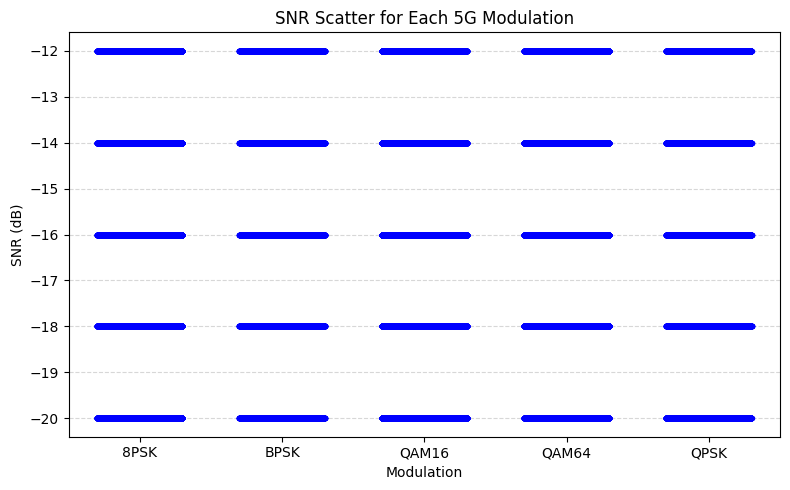

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

DATA_PATH = r"C:\Users\rapur\Downloads\radioml_5g_balanced_100k.h5"
five_g_indices = [0, 3, 7, 8, 9]  # 8PSK, BPSK, QAM16, QAM64, QPSK
MOD_NAMES = ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK',
    'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'OOK',
    'APSK16', 'APSK32', 'DQPSK', 'FSK8', 'MSK', 'OQPSK',
    'QAM128', 'QAM256', 'QAM32', 'QAM8', 'PSK2', 'PSK4']

with h5py.File(DATA_PATH, 'r') as f:
    Y = np.array(f['Y'])          # (N, 24)
    Z = np.array(f['Z']).flatten()  # (N,)
    labels = np.argmax(Y, axis=1)   # (N,)

    # Collect SNR and mod name for relevant classes
    snr_list = []
    mod_list = []
    for idx in five_g_indices:
        mask = labels == idx
        snr_vals = Z[mask]
        snr_list.extend(snr_vals)
        mod_list.extend([MOD_NAMES[idx]] * len(snr_vals))

# Create dataframe for plotting
df = pd.DataFrame({'Modulation': mod_list, 'SNR': snr_list})

plt.figure(figsize=(8, 5))
sns.stripplot(data=df, x='Modulation', y='SNR', jitter=0.3, size=4, color='b')
plt.title("SNR Scatter for Each 5G Modulation")
plt.ylabel("SNR (dB)")
plt.xlabel("Modulation")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [2]:
import h5py
import numpy as np

input_path = r"C:\Users\rapur\Downloads\radioml_5g_filtered.h5"
output_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5"

# QAM16 and QAM64 indices in your label set
qam_indices = [7, 8]  # QAM16: 7, QAM64: 8
samples_per_class = 50_000
total_samples = samples_per_class * 2

with h5py.File(input_path, 'r') as hf:
    X = hf['X'][:]
    Y = hf['Y'][:]
    Z = hf['Z'][:]
    labels = np.argmax(Y, axis=1)

    X_selected = []
    Y_selected = []
    Z_selected = []

    for idx in qam_indices:
        class_indices = np.where(labels == idx)[0]
        sampled_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        X_selected.append(X[sampled_indices])
        Y_selected.append(Y[sampled_indices])
        Z_selected.append(Z[sampled_indices])

    X_selected = np.concatenate(X_selected, axis=0)
    Y_selected = np.concatenate(Y_selected, axis=0)
    Z_selected = np.concatenate(Z_selected, axis=0)

# Shuffle the dataset for better mixing
shuffle_indices = np.random.permutation(total_samples)
X_selected = X_selected[shuffle_indices]
Y_selected = Y_selected[shuffle_indices]
Z_selected = Z_selected[shuffle_indices]

# Save to new HDF5 file
with h5py.File(output_path, 'w') as out_hf:
    out_hf.create_dataset('X', data=X_selected)
    out_hf.create_dataset('Y', data=Y_selected)
    out_hf.create_dataset('Z', data=Z_selected)

print("✅ 100k QAM16/QAM64-only RadioML subset saved successfully!")
print("Saved to:", output_path)
print("Shape:", X_selected.shape, Y_selected.shape, Z_selected.shape)


✅ 100k QAM16/QAM64-only RadioML subset saved successfully!
Saved to: C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5
Shape: (100000, 1024, 2) (100000, 24) (100000, 1)


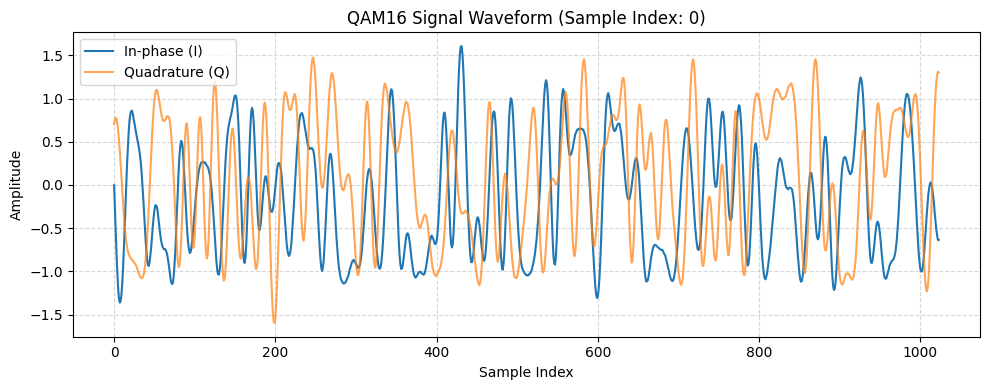

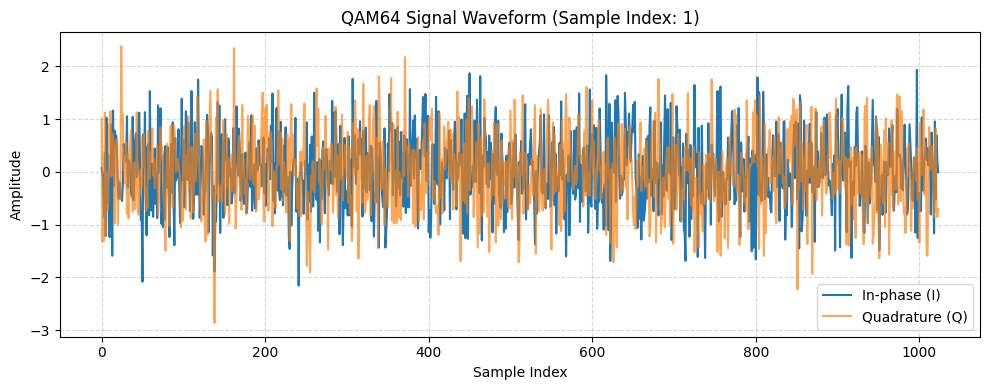

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5"
qam_indices = [7, 8]
mod_names = ['QAM16', 'QAM64']

with h5py.File(data_path, 'r') as f:
    X = np.array(f['X'])
    Y = np.array(f['Y'])
    labels = np.argmax(Y, axis=1)

    for idx, mod in zip(qam_indices, mod_names):
        sample_idx = np.where(labels == idx)[0][0]
        signal = X[sample_idx]  # (1024, 2)

        I = signal[:, 0]
        Q = signal[:, 1]
        t = np.arange(len(I))

        plt.figure(figsize=(10, 4))
        plt.plot(t, I, label='In-phase (I)')
        plt.plot(t, Q, label='Quadrature (Q)', alpha=0.7)
        plt.title(f"{mod} Signal Waveform (Sample Index: {sample_idx})")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


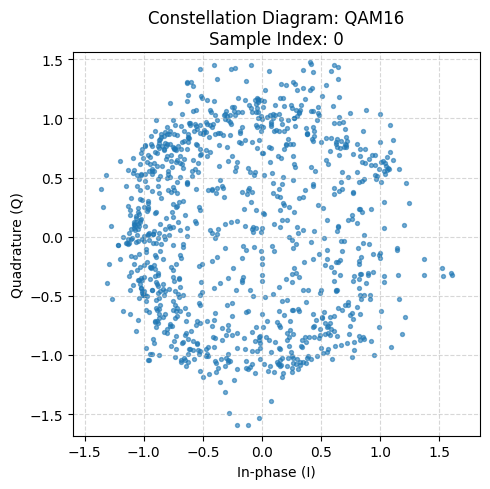

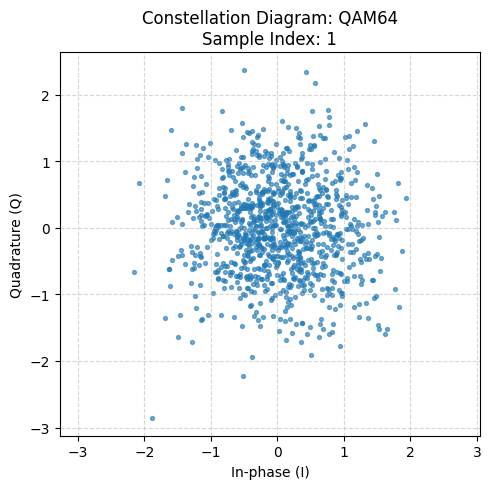

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5"
qam_indices = [7, 8]
mod_names = ['QAM16', 'QAM64']

with h5py.File(data_path, 'r') as f:
    X = np.array(f['X'])
    Y = np.array(f['Y'])
    labels = np.argmax(Y, axis=1)

    for idx, mod in zip(qam_indices, mod_names):
        # Find the first sample of this class
        sample_idx = np.where(labels == idx)[0][0]
        signal = X[sample_idx]  # Shape: (1024, 2)

        I = signal[:, 0]
        Q = signal[:, 1]

        plt.figure(figsize=(5,5))
        plt.scatter(I, Q, s=8, alpha=0.6)
        plt.title(f"Constellation Diagram: {mod}\nSample Index: {sample_idx}")
        plt.xlabel("In-phase (I)")
        plt.ylabel("Quadrature (Q)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()


Number of elements in each class:
QAM16: 50000
QAM64: 50000


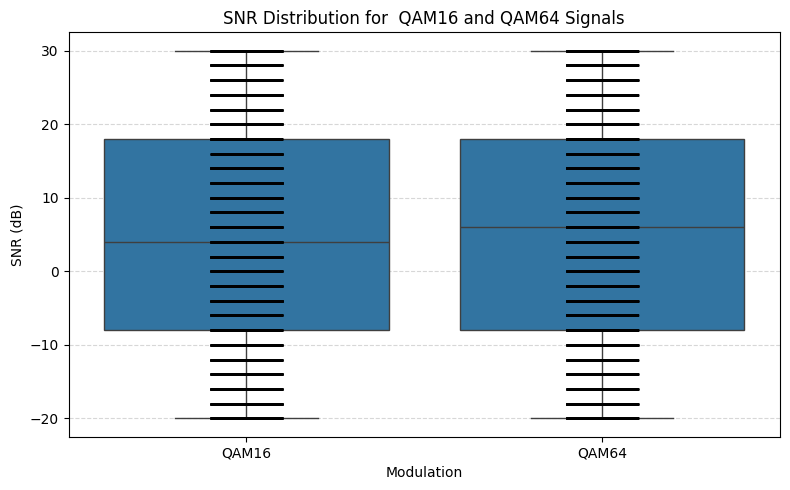

In [27]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5"
MOD_NAMES = ['QAM16', 'QAM64']
qam_indices = [7, 8]

with h5py.File(data_path, 'r') as f:
    Y = np.array(f['Y'])          # Shape: (100000, 24)
    Z = np.array(f['Z']).flatten()  # Shape: (100000,)
    labels = np.argmax(Y, axis=1)   # Shape: (100000,)

    # Count samples per class
    counts = [(mod, np.sum(labels == idx)) for mod, idx in zip(MOD_NAMES, qam_indices)]

    print("Number of elements in each class:")
    for mod, count in counts:
        print(f"{mod}: {count}")

    # Prepare SNRs per class for visualization
    snr_list = []
    mod_list = []
    for mod, idx in zip(MOD_NAMES, qam_indices):
        snr_vals = Z[labels == idx]
        snr_list.extend(snr_vals)
        mod_list.extend([mod] * len(snr_vals))

# Create DataFrame for plotting
df = pd.DataFrame({'Modulation': mod_list, 'SNR': snr_list})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Modulation', y='SNR', showfliers=False)
sns.stripplot(data=df, x='Modulation', y='SNR', color='k', alpha=0.25, size=2)
plt.title("SNR Distribution for  QAM16 and QAM64 Signals")
plt.ylabel("SNR (dB)")
plt.xlabel("Modulation")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [6]:
import h5py
import numpy as np
import pandas as pd

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5"
MOD_NAMES = ['QAM16', 'QAM64']
qam_indices = [7, 8]

# Define SNR bins (edges)
snr_bins = [-20, -10, 0, 10, 20, 30, 100]  # The last bin captures anything above 30, but you likely only have up to 30

with h5py.File(data_path, 'r') as f:
    Y = np.array(f['Y'])
    Z = np.array(f['Z']).flatten()
    labels = np.argmax(Y, axis=1)

    for mod, idx in zip(MOD_NAMES, qam_indices):
        snr_vals = Z[labels == idx]
        counts, bin_edges = np.histogram(snr_vals, bins=snr_bins)
        print(f"\nSNR Distribution for {mod}:")
        for i in range(len(snr_bins)-1):
            print(f"  {snr_bins[i]} <= SNR < {snr_bins[i+1]} : {counts[i]} signals")



SNR Distribution for QAM16:
  -20 <= SNR < -10 : 9571 signals
  -10 <= SNR < 0 : 9650 signals
  0 <= SNR < 10 : 9665 signals
  10 <= SNR < 20 : 9586 signals
  20 <= SNR < 30 : 9583 signals
  30 <= SNR < 100 : 1945 signals

SNR Distribution for QAM64:
  -20 <= SNR < -10 : 9618 signals
  -10 <= SNR < 0 : 9473 signals
  0 <= SNR < 10 : 9624 signals
  10 <= SNR < 20 : 9562 signals
  20 <= SNR < 30 : 9765 signals
  30 <= SNR < 100 : 1958 signals


In [3]:
import h5py
import numpy as np

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5"
MOD_NAMES = ['QAM16', 'QAM64']
qam_indices = [7, 8]

with h5py.File(data_path, 'r') as f:
    X = np.array(f['X'])          # (100000, 1024, 2)
    Y = np.array(f['Y'])          # (100000, 24)
    Z = np.array(f['Z']).flatten()  # (100000,)
    labels = np.argmax(Y, axis=1)   # (100000,)

    # For each existing class, print details needed for augmentation
    for mod, idx in zip(MOD_NAMES, qam_indices):
        idxs = np.where(labels == idx)[0]
        x_mod = X[idxs]
        y_mod = Y[idxs]
        z_mod = Z[idxs]

        print(f"\n===== {mod} (Noisy) =====")
        print(f"  Number of signals: {x_mod.shape[0]}")
        print(f"  Signal shape: {x_mod.shape[1:]}")
        print(f"  Mean signal power: {(x_mod[...,0]**2 + x_mod[...,1]**2).mean():.4f}")
        print(f"  SNR range: min={z_mod.min()}, max={z_mod.max()}, mean={z_mod.mean():.2f}, std={z_mod.std():.2f}")

    # General signal format/power check (for synthetic)
    print("\n===== For Clean Signal Generation =====")
    print(f"  Each synthetic signal should have shape: {X.shape[1:]}")
    print(f"  Normalize each signal to mean power ~1.0")
    print(f"  Use higher SNRs for clean signals (e.g., 18-30 dB, see previous advice)")
    print(f"  Data type: float32, stored as [n_samples, 1024, 2]")



===== QAM16 (Noisy) =====
  Number of signals: 50000
  Signal shape: (1024, 2)
  Mean signal power: 1.0030
  SNR range: min=-20, max=30, mean=5.00, std=14.99

===== QAM64 (Noisy) =====
  Number of signals: 50000
  Signal shape: (1024, 2)
  Mean signal power: 1.0029
  SNR range: min=-20, max=30, mean=5.10, std=15.03

===== For Clean Signal Generation =====
  Each synthetic signal should have shape: (1024, 2)
  Normalize each signal to mean power ~1.0
  Use higher SNRs for clean signals (e.g., 18-30 dB, see previous advice)
  Data type: float32, stored as [n_samples, 1024, 2]


In [7]:
import h5py
import numpy as np

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5"
output_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_4class.h5"
qam_indices = [7, 8]  # QAM16, QAM64

with h5py.File(data_path, 'r') as f:
    X = np.array(f['X'])          # (100000, 1024, 2)
    Y = np.array(f['Y'])          # (100000, 24)
    Z = np.array(f['Z']).flatten()  # (100000,)
    labels = np.argmax(Y, axis=1)

    # Prepare containers for each class
    X_4class, new_labels = [], []

    # 0: QAM16 noisy (<20), 1: QAM16 clean (>=20)
    # 2: QAM64 noisy (<20), 3: QAM64 clean (>=20)
    for i, idx in enumerate(qam_indices):
        # Get indices for current modulation
        mod_mask = (labels == idx)
        snrs = Z[mod_mask]
        X_mod = X[mod_mask]
        n = X_mod.shape[0]

        for j in range(n):
            if snrs[j] < 20:
                X_4class.append(X_mod[j])
                new_labels.append(i * 2 + 0)  # 0 or 2
            else:
                X_4class.append(X_mod[j])
                new_labels.append(i * 2 + 1)  # 1 or 3

    X_4class = np.stack(X_4class, axis=0)
    new_labels = np.array(new_labels, dtype=np.int64)

    print("Class distribution (labels 0: noisy16, 1: clean16, 2: noisy64, 3: clean64):")
    for i in range(4):
        print(f"  Class {i}: {np.sum(new_labels==i)} samples")

# Save to new HDF5
with h5py.File(output_path, 'w') as out_hf:
    out_hf.create_dataset('X', data=X_4class)
    out_hf.create_dataset('label', data=new_labels)
print("✅ 4-class QAM16/QAM64 dataset saved successfully!")
print("Saved to:", output_path)
print("Shape:", X_4class.shape, new_labels.shape)


Class distribution (labels 0: noisy16, 1: clean16, 2: noisy64, 3: clean64):
  Class 0: 38472 samples
  Class 1: 11528 samples
  Class 2: 38277 samples
  Class 3: 11723 samples
✅ 4-class QAM16/QAM64 dataset saved successfully!
Saved to: C:\Users\rapur\Downloads\radioml_qam16_qam64_4class.h5
Shape: (100000, 1024, 2) (100000,)


In [8]:
import h5py
import numpy as np

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_4class.h5"
output_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_4class_strat_balanced.h5"

# Desired balanced count for each class (from previous min)
balanced_count = 11528  # Use min(clean_qam16, clean_qam64)

# SNR bins for stratification (for noisy classes)
snr_bins = [-20, -10, 0, 10, 20]
bin_labels = ['-20 to -10', '-10 to 0', '0 to 10', '10 to 20']

with h5py.File(data_path, 'r') as f:
    X = np.array(f['X'])
    labels = np.array(f['label'])
    # For stratification, reload original Z
    orig_data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_100k.h5"
    with h5py.File(orig_data_path, 'r') as origf:
        Z = np.array(origf['Z']).flatten()
        Y = np.array(origf['Y'])
        orig_labels = np.argmax(Y, axis=1)
    
    # Prepare new lists
    X_final, y_final = [], []

    for class_idx in range(4):
        # Get indices for this class
        indices = np.where(labels == class_idx)[0]
        if class_idx in [0, 2]:  # Noisy QAM16/QAM64 (<20dB)
            # Get modulation index (7 for QAM16, 8 for QAM64)
            mod_idx = 7 if class_idx == 0 else 8
            mod_indices = np.where(orig_labels == mod_idx)[0]
            snr_values = Z[mod_indices]
            snr_mask = snr_values < 20
            snr_in_range_indices = mod_indices[snr_mask]
            # For each SNR bin, sample proportionally
            total_in_range = np.sum(snr_mask)
            samples_needed = balanced_count
            for i in range(len(snr_bins)-1):
                bin_mask = (snr_values >= snr_bins[i]) & (snr_values < snr_bins[i+1])
                bin_indices = mod_indices[bin_mask & snr_mask]
                bin_count = len(bin_indices)
                portion = bin_count / total_in_range
                take_n = int(np.round(portion * samples_needed))
                if take_n > bin_count:
                    take_n = bin_count
                chosen = np.random.choice(bin_indices, take_n, replace=False)
                # Find the corresponding indices in X (via class_indices mapping)
                # X and orig_data have the same order, so chosen can be used directly
                X_final.append(X[chosen])
                y_final.append(np.full(take_n, class_idx, dtype=np.int64))
        else:
            # Clean classes (just random sample)
            chosen = np.random.choice(indices, balanced_count, replace=False)
            X_final.append(X[chosen])
            y_final.append(np.full(balanced_count, class_idx, dtype=np.int64))

    X_final = np.concatenate(X_final, axis=0)
    y_final = np.concatenate(y_final, axis=0)

with h5py.File(output_path, 'w') as f:
    f.create_dataset('X', data=X_final)
    f.create_dataset('label', data=y_final)

print(f"✅ Stratified 4-class balanced QAM16/QAM64 dataset saved: {output_path}")
print("Shape:", X_final.shape, y_final.shape)
for i in range(4):
    print(f"Class {i}: {np.sum(y_final==i)} samples")


✅ Stratified 4-class balanced QAM16/QAM64 dataset saved: C:\Users\rapur\Downloads\radioml_qam16_qam64_4class_strat_balanced.h5
Shape: (46112, 1024, 2) (46112,)
Class 0: 11528 samples
Class 1: 11528 samples
Class 2: 11528 samples
Class 3: 11528 samples


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ==== Hyperparameters ====
BATCH_SIZE = 128
EPOCHS = 50
LR = 2e-4
LAMBDA_L1 = 100  # L1 loss weight

NUM_CLASSES = 2  # QAM16, QAM64
SEQ_LEN = 1024   # Number of I/Q symbols per signal
N_CHANNELS = 2   # I/Q

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==== Helper: One-hot encoding for class labels ====
def one_hot(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

# ==== Dataset Loading ====
import h5py
import numpy as np

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_4class_strat_balanced.h5"
with h5py.File(data_path, 'r') as f:
    X = np.array(f['X'])       # (n_samples, 1024, 2)
    y = np.array(f['label'])   # (n_samples,) 0: noisy16, 1: clean16, 2: noisy64, 3: clean64

# Prepare (noisy, clean, label) tuples
noisy_mask_16 = (y == 0)
clean_mask_16 = (y == 1)
noisy_mask_64 = (y == 2)
clean_mask_64 = (y == 3)

# For each modulation, align noisy and clean (random pairing within class)
def align_pairs(X, mask_noisy, mask_clean, mod_label):
    X_noisy = X[mask_noisy]
    X_clean = X[mask_clean]
    n = min(len(X_noisy), len(X_clean))
    idx_noisy = np.random.choice(len(X_noisy), n, replace=False)
    idx_clean = np.random.choice(len(X_clean), n, replace=False)
    return (X_noisy[idx_noisy], X_clean[idx_clean], np.full(n, mod_label, dtype=np.int64))

Xn16, Xc16, yl16 = align_pairs(X, noisy_mask_16, clean_mask_16, 0)
Xn64, Xc64, yl64 = align_pairs(X, noisy_mask_64, clean_mask_64, 1)

# Combine all
X_noisy = np.concatenate([Xn16, Xn64], axis=0)
X_clean = np.concatenate([Xc16, Xc64], axis=0)
y_label = np.concatenate([yl16, yl64], axis=0)

# Convert to torch tensors
X_noisy = torch.tensor(X_noisy, dtype=torch.float32)
X_clean = torch.tensor(X_clean, dtype=torch.float32)
y_label = torch.tensor(y_label, dtype=torch.long)

# Create dataset and dataloader
dataset = TensorDataset(X_noisy, X_clean, y_label)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# ==== Model Definitions ====

class Generator(nn.Module):
    def __init__(self, n_channels=N_CHANNELS, seq_len=SEQ_LEN, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_emb = nn.Linear(num_classes, seq_len)
        self.net = nn.Sequential(
            nn.Conv1d(n_channels+1, 64, 7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, 7, padding=3),
            nn.ReLU(),
            nn.Conv1d(128, 64, 7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, n_channels, 7, padding=3),
        )
    def forward(self, x, labels):
        # x: (B, 1024, 2) -> (B, 2, 1024)
        x = x.permute(0, 2, 1)
        # labels: (B,) or (B, num_classes)
        oh = one_hot(labels, NUM_CLASSES).to(x.device) if labels.ndim == 1 else labels
        lab_channel = self.label_emb(oh).unsqueeze(1)  # (B,1,1024)
        x_in = torch.cat([x, lab_channel], dim=1)  # (B,3,1024)
        out = self.net(x_in)
        out = out.permute(0, 2, 1)  # (B,1024,2)
        return out

class Discriminator(nn.Module):
    def __init__(self, n_channels=N_CHANNELS, seq_len=SEQ_LEN, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_emb = nn.Linear(num_classes, seq_len)
        self.net = nn.Sequential(
            nn.Conv1d(n_channels+1, 64, 7, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, 7, padding=3),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128*seq_len, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, labels):
        x = x.permute(0, 2, 1)
        oh = one_hot(labels, NUM_CLASSES).to(x.device) if labels.ndim == 1 else labels
        lab_channel = self.label_emb(oh).unsqueeze(1)
        x_in = torch.cat([x, lab_channel], dim=1)
        return self.net(x_in)

# ==== Instantiate models and optimizers ====
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

# ==== Loss functions ====
criterion_adv = nn.BCELoss()
criterion_l1 = nn.L1Loss()

# ==== Training Loop ====
for epoch in range(EPOCHS):
    for noisy, clean, label in dataloader:
        noisy, clean, label = noisy.to(DEVICE), clean.to(DEVICE), label.to(DEVICE)
        batch_size = noisy.size(0)
        real = torch.ones((batch_size, 1), device=DEVICE)
        fake = torch.zeros((batch_size, 1), device=DEVICE)

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        out_real = discriminator(clean, label)
        out_fake = discriminator(generator(noisy, label).detach(), label)
        loss_D_real = criterion_adv(out_real, real)
        loss_D_fake = criterion_adv(out_fake, fake)
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        optimizer_G.zero_grad()
        fake_clean = generator(noisy, label)
        out_fake = discriminator(fake_clean, label)
        loss_G_adv = criterion_adv(out_fake, real)
        loss_G_l1 = criterion_l1(fake_clean, clean)
        loss_G = loss_G_adv + LAMBDA_L1 * loss_G_l1
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | D Loss: {loss_D.item():.4f} | G Adv: {loss_G_adv.item():.4f} | G L1: {loss_G_l1.item():.4f} | G Total: {loss_G.item():.4f}")

print("Training complete!")


Epoch 1/50 | D Loss: 0.0012 | G Adv: 8.0669 | G L1: 0.7653 | G Total: 84.5922
Epoch 2/50 | D Loss: 0.0001 | G Adv: 13.1721 | G L1: 0.7060 | G Total: 83.7709
Epoch 3/50 | D Loss: 0.1238 | G Adv: 4.2279 | G L1: 0.7282 | G Total: 77.0466
Epoch 4/50 | D Loss: 0.2386 | G Adv: 5.1735 | G L1: 0.7840 | G Total: 83.5726
Epoch 5/50 | D Loss: 0.2045 | G Adv: 5.9200 | G L1: 0.8072 | G Total: 86.6393
Epoch 6/50 | D Loss: 0.1971 | G Adv: 2.8394 | G L1: 0.7895 | G Total: 81.7844
Epoch 7/50 | D Loss: 0.3102 | G Adv: 3.9321 | G L1: 0.7879 | G Total: 82.7223
Epoch 8/50 | D Loss: 0.0815 | G Adv: 2.7063 | G L1: 0.7638 | G Total: 79.0900
Epoch 9/50 | D Loss: 0.4138 | G Adv: 3.3968 | G L1: 0.7883 | G Total: 82.2259
Epoch 10/50 | D Loss: 0.8842 | G Adv: 1.4293 | G L1: 0.8237 | G Total: 83.8002
Epoch 11/50 | D Loss: 0.2631 | G Adv: 2.4692 | G L1: 0.7902 | G Total: 81.4844
Epoch 12/50 | D Loss: 0.4390 | G Adv: 0.8584 | G L1: 0.8061 | G Total: 81.4687
Epoch 13/50 | D Loss: 0.3688 | G Adv: 1.0598 | G L1: 0.8001 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 128
EPOCHS = 50
LR_G = 2e-4
LR_D = 1e-4
LAMBDA_L1 = 50
NUM_CLASSES = 2
SEQ_LEN = 1024
N_CHANNELS = 2
INSTANCE_NOISE_STD = 0.01  # Standard deviation for instance noise

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def one_hot(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

# ==== Dataset loading as before ====
import h5py
import numpy as np

data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_4class_strat_balanced.h5"
with h5py.File(data_path, 'r') as f:
    X = np.array(f['X'])
    y = np.array(f['label'])

noisy_mask_16 = (y == 0)
clean_mask_16 = (y == 1)
noisy_mask_64 = (y == 2)
clean_mask_64 = (y == 3)

def align_pairs(X, mask_noisy, mask_clean, mod_label):
    X_noisy = X[mask_noisy]
    X_clean = X[mask_clean]
    n = min(len(X_noisy), len(X_clean))
    idx_noisy = np.random.choice(len(X_noisy), n, replace=False)
    idx_clean = np.random.choice(len(X_clean), n, replace=False)
    return (X_noisy[idx_noisy], X_clean[idx_clean], np.full(n, mod_label, dtype=np.int64))

Xn16, Xc16, yl16 = align_pairs(X, noisy_mask_16, clean_mask_16, 0)
Xn64, Xc64, yl64 = align_pairs(X, noisy_mask_64, clean_mask_64, 1)
X_noisy = np.concatenate([Xn16, Xn64], axis=0)
X_clean = np.concatenate([Xc16, Xc64], axis=0)
y_label = np.concatenate([yl16, yl64], axis=0)

X_noisy = torch.tensor(X_noisy, dtype=torch.float32)
X_clean = torch.tensor(X_clean, dtype=torch.float32)
y_label = torch.tensor(y_label, dtype=torch.long)
dataset = TensorDataset(X_noisy, X_clean, y_label)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# ==== Models ====

class Generator(nn.Module):
    def __init__(self, n_channels=N_CHANNELS, seq_len=SEQ_LEN, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_emb = nn.Linear(num_classes, seq_len)
        self.net = nn.Sequential(
            nn.Conv1d(n_channels+1, 128, 7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, 7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, 7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 64, 7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, n_channels, 7, padding=3),
        )
    def forward(self, x, labels):
        x = x.permute(0, 2, 1)
        oh = one_hot(labels, NUM_CLASSES).to(x.device) if labels.ndim == 1 else labels
        lab_channel = self.label_emb(oh).unsqueeze(1)
        x_in = torch.cat([x, lab_channel], dim=1)
        out = self.net(x_in)
        out = out.permute(0, 2, 1)
        return out

class Discriminator(nn.Module):
    def __init__(self, n_channels=N_CHANNELS, seq_len=SEQ_LEN, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_emb = nn.Linear(num_classes, seq_len)
        self.net = nn.Sequential(
            nn.Conv1d(n_channels+1, 128, 7, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 7, padding=3),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128*seq_len, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, labels):
        x = x.permute(0, 2, 1)
        oh = one_hot(labels, NUM_CLASSES).to(x.device) if labels.ndim == 1 else labels
        lab_channel = self.label_emb(oh).unsqueeze(1)
        x_in = torch.cat([x, lab_channel], dim=1)
        return self.net(x_in)

generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))

criterion_adv = nn.BCELoss()
criterion_l1 = nn.L1Loss()

# ==== Training Loop with Improvements ====
for epoch in range(EPOCHS):
    for noisy, clean, label in dataloader:
        noisy, clean, label = noisy.to(DEVICE), clean.to(DEVICE), label.to(DEVICE)
        batch_size = noisy.size(0)
        real = torch.full((batch_size, 1), 0.9, device=DEVICE)  # label smoothing: 0.9 instead of 1
        fake = torch.zeros((batch_size, 1), device=DEVICE)

        # Instance noise: add to D inputs
        noise_real = torch.randn_like(clean) * INSTANCE_NOISE_STD
        noise_fake = torch.randn_like(noisy) * INSTANCE_NOISE_STD

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        out_real = discriminator(clean + noise_real, label)
        fake_gen = generator(noisy, label)
        out_fake = discriminator(fake_gen.detach() + noise_fake, label)
        loss_D_real = criterion_adv(out_real, real)
        loss_D_fake = criterion_adv(out_fake, fake)
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # ---- Train Generator (can do twice per loop for extra boost) ----
        for _ in range(2):  # 2 G updates per D step
            optimizer_G.zero_grad()
            fake_clean = generator(noisy, label)
            out_fake_g = discriminator(fake_clean + noise_fake, label)
            loss_G_adv = criterion_adv(out_fake_g, real)
            loss_G_l1 = criterion_l1(fake_clean, clean)
            loss_G = loss_G_adv + LAMBDA_L1 * loss_G_l1
            loss_G.backward()
            optimizer_G.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | D Loss: {loss_D.item():.4f} | G Adv: {loss_G_adv.item():.4f} | G L1: {loss_G_l1.item():.4f} | G Total: {loss_G.item():.4f}")

print("Training complete!")


Epoch 1/50 | D Loss: 0.5093 | G Adv: 2.5776 | G L1: 0.7574 | G Total: 40.4489
Epoch 2/50 | D Loss: 0.4354 | G Adv: 0.9802 | G L1: 0.8085 | G Total: 41.4028
Epoch 3/50 | D Loss: 0.6442 | G Adv: 1.7606 | G L1: 0.7857 | G Total: 41.0441
Epoch 4/50 | D Loss: 0.7701 | G Adv: 1.6111 | G L1: 0.8034 | G Total: 41.7815
Epoch 5/50 | D Loss: 0.6935 | G Adv: 0.9169 | G L1: 0.8266 | G Total: 42.2456
Epoch 6/50 | D Loss: 0.7364 | G Adv: 1.1045 | G L1: 0.8260 | G Total: 42.4031
Epoch 7/50 | D Loss: 0.5387 | G Adv: 0.7423 | G L1: 0.8171 | G Total: 41.5993
Epoch 8/50 | D Loss: 0.5674 | G Adv: 0.8783 | G L1: 0.8170 | G Total: 41.7280
Epoch 9/50 | D Loss: 0.6740 | G Adv: 0.7869 | G L1: 0.8229 | G Total: 41.9303
Epoch 10/50 | D Loss: 0.7424 | G Adv: 1.2773 | G L1: 0.8026 | G Total: 41.4090
Epoch 11/50 | D Loss: 0.7587 | G Adv: 1.3057 | G L1: 0.8079 | G Total: 41.6983
Epoch 12/50 | D Loss: 0.5014 | G Adv: 0.9350 | G L1: 0.8148 | G Total: 41.6749
Epoch 13/50 | D Loss: 0.4910 | G Adv: 0.8251 | G L1: 0.8122 |

In [11]:
import torch

# Suppose your model objects are named `generator` and `discriminator`
# Recommended: save only .state_dict() (best practice for PyTorch)

torch.save(generator.state_dict(), 'qam16_64_generator.pth')
torch.save(discriminator.state_dict(), 'qam16_64_discriminator.pth')

print("Models saved as 'qam16_64_generator.pth' and 'qam16_64_discriminator.pth'")


Models saved as 'qam16_64_generator.pth' and 'qam16_64_discriminator.pth'


SNR before GAN: -3.15 dB
SNR after  GAN: -2.86 dB


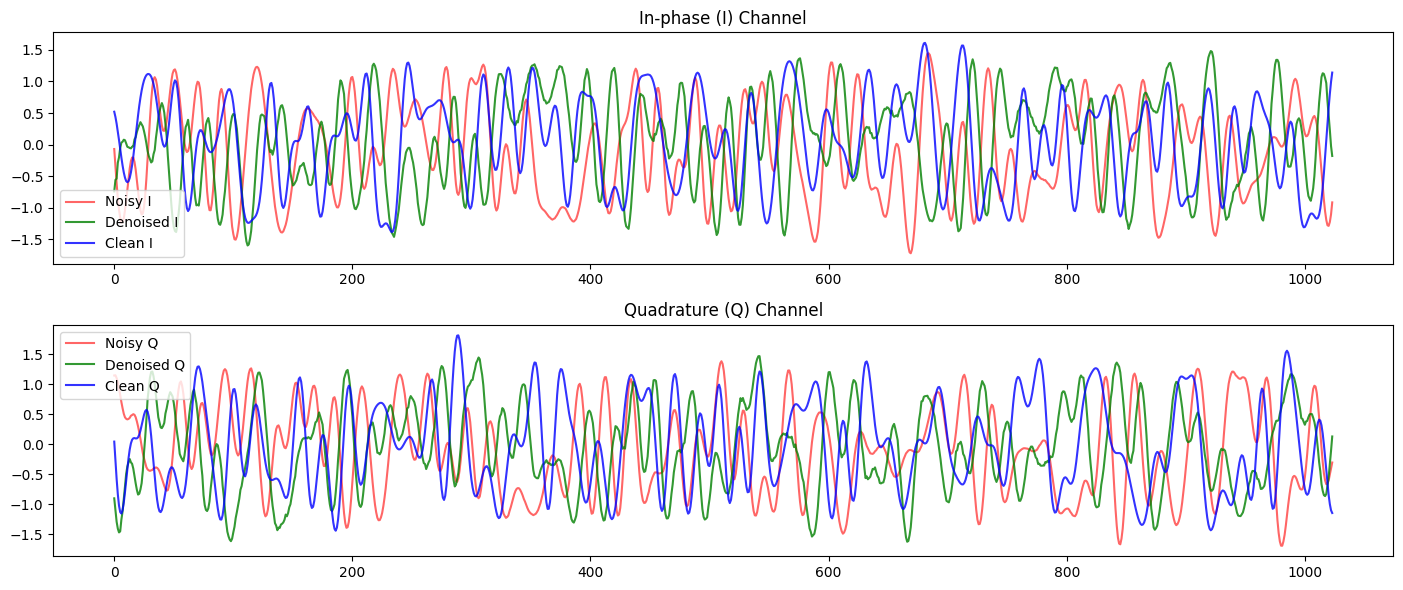

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- If needed, reload your models first (optional) ---
# generator = Generator().to(DEVICE)
# generator.load_state_dict(torch.load('qam16_64_generator.pth'))
# generator.eval()

# ==== Helper to Compute SNR ====
def compute_snr(clean, denoised):
    clean = np.asarray(clean)
    denoised = np.asarray(denoised)
    signal_power = np.mean(clean**2)
    noise_power = np.mean((clean - denoised)**2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-12))
    return snr

# ==== Pick a random sample ====
idx = np.random.randint(0, len(X_noisy))
noisy_ex = X_noisy[idx:idx+1].to(DEVICE)   # shape (1, 1024, 2)
clean_ex = X_clean[idx:idx+1].cpu().numpy()[0]
label_ex = y_label[idx:idx+1].to(DEVICE)

# ==== Generate denoised output ====
generator.eval()
with torch.no_grad():
    denoised_ex = generator(noisy_ex, label_ex).cpu().numpy()[0]

noisy_ex_np = noisy_ex.cpu().numpy()[0]

# ==== Compute SNRs ====
snr_before = compute_snr(clean_ex, noisy_ex_np)
snr_after = compute_snr(clean_ex, denoised_ex)
print(f"SNR before GAN: {snr_before:.2f} dB")
print(f"SNR after  GAN: {snr_after:.2f} dB")

# ==== Plot I/Q waveforms ====
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(noisy_ex_np[:,0], label="Noisy I", color='red', alpha=0.6)
plt.plot(denoised_ex[:,0], label="Denoised I", color='green', alpha=0.8)
plt.plot(clean_ex[:,0], label="Clean I", color='blue', alpha=0.8)
plt.title("In-phase (I) Channel")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(noisy_ex_np[:,1], label="Noisy Q", color='red', alpha=0.6)
plt.plot(denoised_ex[:,1], label="Denoised Q", color='green', alpha=0.8)
plt.plot(clean_ex[:,1], label="Clean Q", color='blue', alpha=0.8)
plt.title("Quadrature (Q) Channel")
plt.legend()

plt.tight_layout()
plt.show()


SNR I Before: -2.88 dB | After: -2.82 dB
SNR Q Before: -2.92 dB | After: -1.97 dB


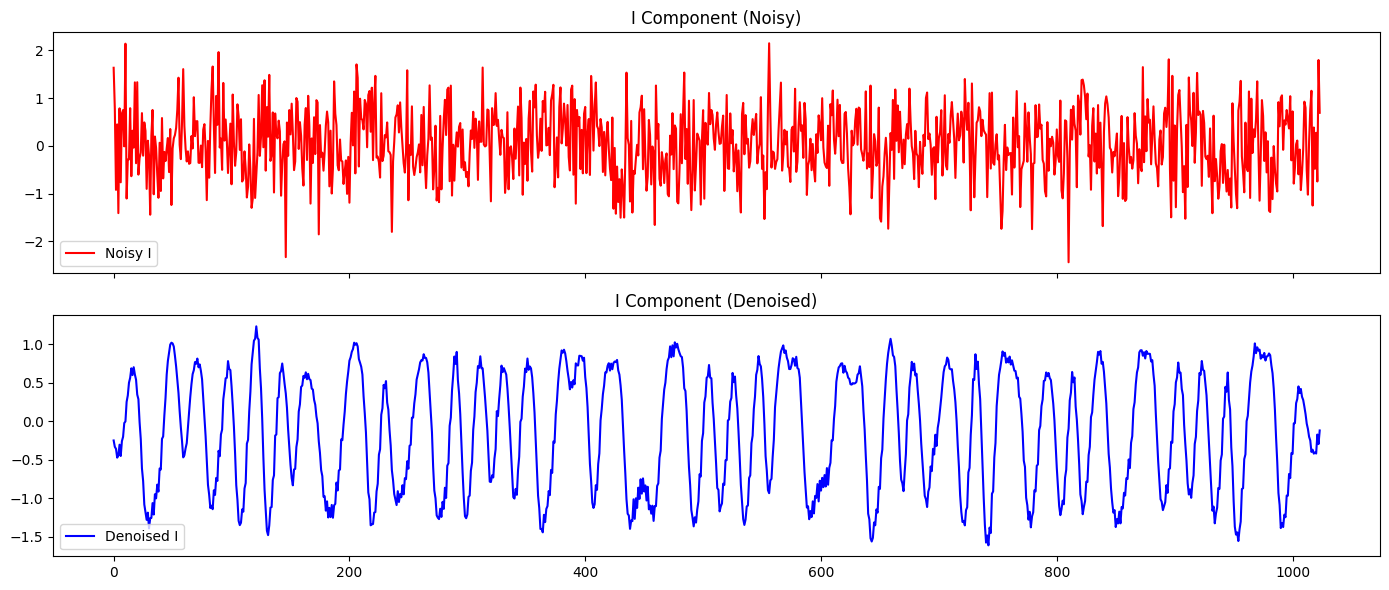

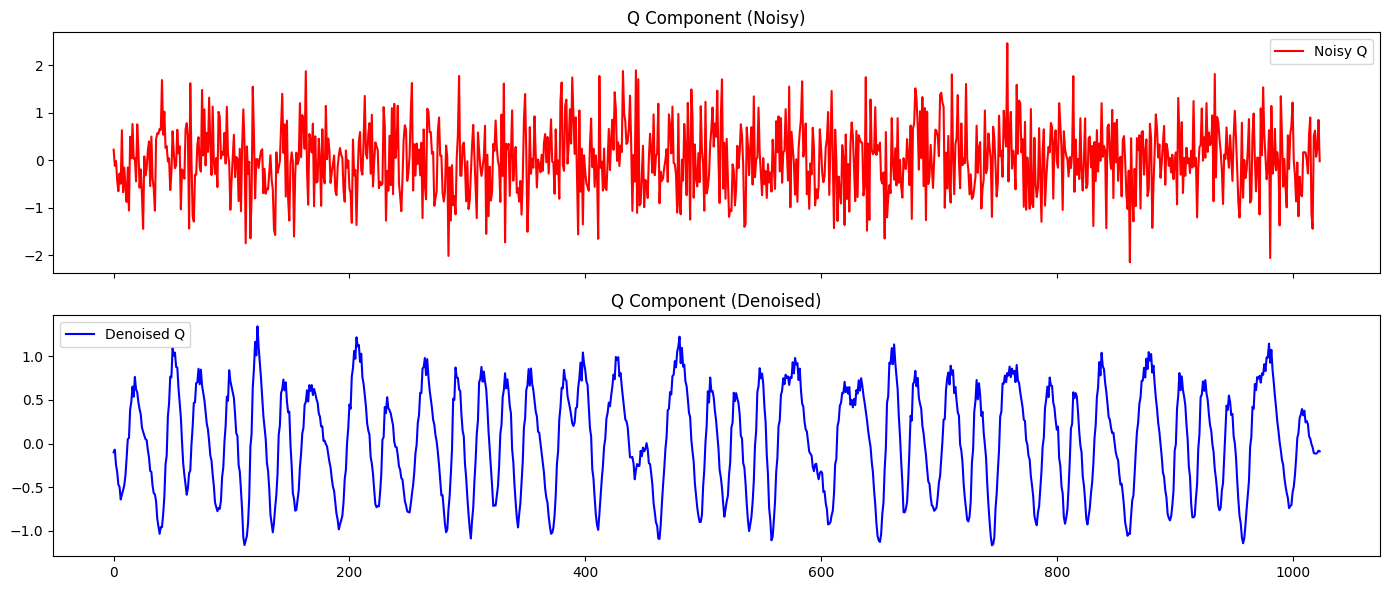

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ==== Randomly select a sample ====
idx = np.random.randint(0, len(X_noisy))
noisy_signal = X_noisy[idx:idx+1].to(DEVICE)
clean_signal = X_clean[idx].cpu().numpy()
label = y_label[idx:idx+1].to(DEVICE)

# ==== Denoise ====
generator.eval()
with torch.no_grad():
    denoised = generator(noisy_signal, label).cpu().squeeze(0).numpy()
noisy_signal_np = noisy_signal.cpu().squeeze(0).numpy()

# ==== Compute SNR ====
def snr(clean, denoised):
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - denoised) ** 2)
    return 10 * np.log10(signal_power / (noise_power + 1e-12))

snr_i_before = snr(clean_signal[:,0], noisy_signal_np[:,0])
snr_i_after = snr(clean_signal[:,0], denoised[:,0])
snr_q_before = snr(clean_signal[:,1], noisy_signal_np[:,1])
snr_q_after = snr(clean_signal[:,1], denoised[:,1])

print(f"SNR I Before: {snr_i_before:.2f} dB | After: {snr_i_after:.2f} dB")
print(f"SNR Q Before: {snr_q_before:.2f} dB | After: {snr_q_after:.2f} dB")

# ==== Visualization: ONLY before and after ====
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axs[0].plot(noisy_signal_np[:,0], color='red', label='Noisy I')
axs[0].set_title("I Component (Noisy)")
axs[0].legend()

axs[1].plot(denoised[:,0], color='blue', label='Denoised I')
axs[1].set_title("I Component (Denoised)")
axs[1].legend()

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axs[0].plot(noisy_signal_np[:,1], color='red', label='Noisy Q')
axs[0].set_title("Q Component (Noisy)")
axs[0].legend()

axs[1].plot(denoised[:,1], color='blue', label='Denoised Q')
axs[1].set_title("Q Component (Denoised)")
axs[1].legend()

plt.tight_layout()
plt.show()


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import h5py
import matplotlib.pyplot as plt

# ==== Config ====
BATCH_SIZE = 128
EPOCHS = 100
LR_G = 2e-4
LR_D = 1e-4
LAMBDA_L1 = 100
LAMBDA_L2 = 10
NUM_CLASSES = 2
SEQ_LEN = 1024
N_CHANNELS = 2
INSTANCE_NOISE_STD = 0.01
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==== Utility ====
def one_hot(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

# ==== Load Data ====
data_path = r"C:\Users\rapur\Downloads\radioml_qam16_qam64_4class_strat_balanced.h5"
with h5py.File(data_path, 'r') as f:
    X = np.array(f['X'])
    y = np.array(f['label'])

# ---- Align (noisy, clean) pairs (by class) ----
noisy_mask_16 = (y == 0)
clean_mask_16 = (y == 1)
noisy_mask_64 = (y == 2)
clean_mask_64 = (y == 3)
def align_pairs(X, mask_noisy, mask_clean, mod_label):
    X_noisy = X[mask_noisy]
    X_clean = X[mask_clean]
    n = min(len(X_noisy), len(X_clean))
    idx_noisy = np.random.choice(len(X_noisy), n, replace=False)
    idx_clean = np.random.choice(len(X_clean), n, replace=False)
    return (X_noisy[idx_noisy], X_clean[idx_clean], np.full(n, mod_label, dtype=np.int64))
Xn16, Xc16, yl16 = align_pairs(X, noisy_mask_16, clean_mask_16, 0)
Xn64, Xc64, yl64 = align_pairs(X, noisy_mask_64, clean_mask_64, 1)
X_noisy = np.concatenate([Xn16, Xn64], axis=0)
X_clean = np.concatenate([Xc16, Xc64], axis=0)
y_label = np.concatenate([yl16, yl64], axis=0)
X_noisy = torch.tensor(X_noisy, dtype=torch.float32)
X_clean = torch.tensor(X_clean, dtype=torch.float32)
y_label = torch.tensor(y_label, dtype=torch.long)
dataset = TensorDataset(X_noisy, X_clean, y_label)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# ==== 1D U-Net Generator ====
class UNet1DGenerator(nn.Module):
    def __init__(self, n_channels=N_CHANNELS, seq_len=SEQ_LEN, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_emb = nn.Linear(num_classes, seq_len)
        # Encoder
        self.enc1 = nn.Conv1d(n_channels+1, 64, 7, padding=3)
        self.enc2 = nn.Conv1d(64, 128, 7, stride=2, padding=3)
        self.enc3 = nn.Conv1d(128, 256, 7, stride=2, padding=3)
        # Decoder
        self.dec2 = nn.ConvTranspose1d(256, 128, 4, stride=2, padding=1)
        self.dec1 = nn.ConvTranspose1d(256, 64, 4, stride=2, padding=1)
        self.final = nn.Conv1d(128, n_channels, 7, padding=3)
        self.act = nn.ReLU()
    def forward(self, x, labels):
        x = x.permute(0, 2, 1)  # (B,2,1024)
        oh = one_hot(labels, NUM_CLASSES).to(x.device) if labels.ndim == 1 else labels
        lab_channel = self.label_emb(oh).unsqueeze(1)
        x = torch.cat([x, lab_channel], dim=1)  # (B,3,1024)
        # Encoder
        e1 = self.act(self.enc1(x))            # (B,64,1024)
        e2 = self.act(self.enc2(e1))           # (B,128,512)
        e3 = self.act(self.enc3(e2))           # (B,256,256)
        # Decoder
        d2 = self.act(self.dec2(e3))           # (B,128,512)
        d2_cat = torch.cat([e2, d2], dim=1)    # (B,256,512)
        d1 = self.act(self.dec1(d2_cat))       # (B,64,1024)
        d1_cat = torch.cat([e1, d1], dim=1)    # (B,128,1024)
        out = self.final(d1_cat)               # (B,2,1024)
        out = out.permute(0, 2, 1)
        return out

# ==== Discriminator (same as before) ====
class Discriminator(nn.Module):
    def __init__(self, n_channels=N_CHANNELS, seq_len=SEQ_LEN, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_emb = nn.Linear(num_classes, seq_len)
        self.net = nn.Sequential(
            nn.Conv1d(n_channels+1, 128, 7, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 7, padding=3),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128*seq_len, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, labels):
        x = x.permute(0, 2, 1)
        oh = one_hot(labels, NUM_CLASSES).to(x.device) if labels.ndim == 1 else labels
        lab_channel = self.label_emb(oh).unsqueeze(1)
        x_in = torch.cat([x, lab_channel], dim=1)
        return self.net(x_in)

generator = UNet1DGenerator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)
optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))
criterion_adv = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_l2 = nn.MSELoss()

# ==== Training Loop ====
for epoch in range(EPOCHS):
    for noisy, clean, label in dataloader:
        noisy, clean, label = noisy.to(DEVICE), clean.to(DEVICE), label.to(DEVICE)
        batch_size = noisy.size(0)
        real = torch.full((batch_size, 1), 0.9, device=DEVICE)  # label smoothing
        fake = torch.zeros((batch_size, 1), device=DEVICE)
        noise_real = torch.randn_like(clean) * INSTANCE_NOISE_STD
        noise_fake = torch.randn_like(noisy) * INSTANCE_NOISE_STD

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        out_real = discriminator(clean + noise_real, label)
        fake_gen = generator(noisy, label)
        out_fake = discriminator(fake_gen.detach() + noise_fake, label)
        loss_D_real = criterion_adv(out_real, real)
        loss_D_fake = criterion_adv(out_fake, fake)
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # ---- Train Generator (twice per D step) ----
        for _ in range(2):
            optimizer_G.zero_grad()
            fake_clean = generator(noisy, label)
            out_fake_g = discriminator(fake_clean + noise_fake, label)
            loss_G_adv = criterion_adv(out_fake_g, real)
            loss_G_l1 = criterion_l1(fake_clean, clean)
            loss_G_l2 = criterion_l2(fake_clean, clean)
            loss_G = loss_G_adv + LAMBDA_L1 * loss_G_l1 + LAMBDA_L2 * loss_G_l2
            loss_G.backward()
            optimizer_G.step()
    print(f"Epoch {epoch+1}/{EPOCHS} | D Loss: {loss_D.item():.4f} | G Adv: {loss_G_adv.item():.4f} | G L1: {loss_G_l1.item():.4f} | G L2: {loss_G_l2.item():.4f} | G Total: {loss_G.item():.4f}")
print("Training complete!")

# ==== SNR Evaluation/Visualization (Single Sample) ====
def compute_snr(clean, denoised):
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - denoised) ** 2)
    return 10 * np.log10(signal_power / (noise_power + 1e-12))

# Pick random sample for demo
idx = np.random.randint(0, len(X_noisy))
noisy_signal = X_noisy[idx:idx+1].to(DEVICE)
clean_signal = X_clean[idx].cpu().numpy()
label = y_label[idx:idx+1].to(DEVICE)
generator.eval()
with torch.no_grad():
    denoised = generator(noisy_signal, label).cpu().squeeze(0).numpy()
noisy_signal_np = noisy_signal.cpu().squeeze(0).numpy()
snr_i_before = compute_snr(clean_signal[:,0], noisy_signal_np[:,0])
snr_i_after = compute_snr(clean_signal[:,0], denoised[:,0])
snr_q_before = compute_snr(clean_signal[:,1], noisy_signal_np[:,1])
snr_q_after = compute_snr(clean_signal[:,1], denoised[:,1])
print(f"SNR I Before: {snr_i_before:.2f} dB | After: {snr_i_after:.2f} dB")
print(f"SNR Q Before: {snr_q_before:.2f} dB | After: {snr_q_after:.2f} dB")

# Visualization: Before and After (I & Q)
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
axs[0].plot(noisy_signal_np[:,0], color='red', label='Noisy I')
axs[0].plot(denoised[:,0], color='blue', label='Denoised I')
axs[0].set_title("I Component: Noisy vs Denoised")
axs[0].legend()
axs[1].plot(noisy_signal_np[:,1], color='red', label='Noisy Q')
axs[1].plot(denoised[:,1], color='blue', label='Denoised Q')
axs[1].set_title("Q Component: Noisy vs Denoised")
axs[1].legend()
plt.tight_layout()
plt.show()


Epoch 1/100 | D Loss: 0.1641 | G Adv: 6.6780 | G L1: 0.6063 | G L2: 0.5069 | G Total: 72.3764
Epoch 2/100 | D Loss: 0.1631 | G Adv: 7.6566 | G L1: 0.6059 | G L2: 0.5045 | G Total: 73.2955
Epoch 3/100 | D Loss: 0.1629 | G Adv: 8.1233 | G L1: 0.6059 | G L2: 0.5102 | G Total: 73.8168
Epoch 4/100 | D Loss: 0.1640 | G Adv: 8.7030 | G L1: 0.6111 | G L2: 0.5172 | G Total: 74.9883
Epoch 5/100 | D Loss: 0.1627 | G Adv: 8.9139 | G L1: 0.6134 | G L2: 0.5252 | G Total: 75.5072
Epoch 6/100 | D Loss: 0.1627 | G Adv: 8.9970 | G L1: 0.6184 | G L2: 0.5347 | G Total: 76.1811
Epoch 7/100 | D Loss: 0.1627 | G Adv: 9.2510 | G L1: 0.6268 | G L2: 0.5550 | G Total: 77.4811
Epoch 8/100 | D Loss: 0.1628 | G Adv: 9.1317 | G L1: 0.6386 | G L2: 0.5827 | G Total: 78.8219
Epoch 9/100 | D Loss: 0.1629 | G Adv: 7.9551 | G L1: 0.6576 | G L2: 0.6309 | G Total: 80.0269
Epoch 10/100 | D Loss: 55.0000 | G Adv: 10.0000 | G L1: 0.6044 | G L2: 0.5023 | G Total: 75.4635


KeyboardInterrupt: 

In [21]:
import torch
import torch.nn as nn

class UNet1DGenerator(nn.Module):
    def __init__(self, n_channels=2, seq_len=1024, num_classes=2):
        super().__init__()
        self.label_emb = nn.Linear(num_classes, seq_len)
        # Encoder
        self.enc1 = nn.Conv1d(n_channels+1, 64, 7, padding=3)
        self.enc2 = nn.Conv1d(64, 128, 7, stride=2, padding=3)
        self.enc3 = nn.Conv1d(128, 256, 7, stride=2, padding=3)
        # Decoder
        self.dec2 = nn.ConvTranspose1d(256, 128, 4, stride=2, padding=1)
        self.dec1 = nn.ConvTranspose1d(256, 64, 4, stride=2, padding=1)
        self.final = nn.Conv1d(128, n_channels, 7, padding=3)
        self.act = nn.ReLU()
    def forward(self, x, labels):
        x = x.permute(0, 2, 1)
        oh = torch.nn.functional.one_hot(labels, num_classes=2).float().to(x.device)
        lab_channel = self.label_emb(oh).unsqueeze(1)
        x = torch.cat([x, lab_channel], dim=1)
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        d2 = self.act(self.dec2(e3))
        d2_cat = torch.cat([e2, d2], dim=1)
        d1 = self.act(self.dec1(d2_cat))
        d1_cat = torch.cat([e1, d1], dim=1)
        out = self.final(d1_cat)
        out = out.permute(0, 2, 1)
        return out
class PatchGAN1DDiscriminator(nn.Module):
    def __init__(self, n_channels=2, seq_len=1024, num_classes=2):
        super().__init__()
        self.label_emb = nn.Linear(num_classes, seq_len)
        self.net = nn.Sequential(
            nn.Conv1d(n_channels+1, 64, 7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, 7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, 7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(256, 1, 7, padding=3),
            nn.Sigmoid()  # Output shape: (batch, 1, patch_count)
        )
    def forward(self, x, labels):
        x = x.permute(0, 2, 1)
        oh = torch.nn.functional.one_hot(labels, num_classes=2).float().to(x.device)
        lab_channel = self.label_emb(oh).unsqueeze(1)
        x = torch.cat([x, lab_channel], dim=1)
        return self.net(x)
import torch.optim as optim
import torch.nn as nn

generator = UNet1DGenerator().to(DEVICE)
discriminator = PatchGAN1DDiscriminator().to(DEVICE)
optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion_adv = nn.BCELoss()
criterion_l1 = nn.L1Loss()
LAMBDA_L1 = 25

NUM_EPOCHS = 25  # <--- Set number of epochs here

for epoch in range(NUM_EPOCHS):
    for noisy, clean, label in dataloader:
        noisy, clean, label = noisy.to(DEVICE), clean.to(DEVICE), label.to(DEVICE)
        batch_size = noisy.size(0)
        real = torch.ones((batch_size, 1, clean.size(1)//8), device=DEVICE)
        fake = torch.zeros((batch_size, 1, clean.size(1)//8), device=DEVICE)

        # Train D
        optimizer_D.zero_grad()
        out_real = discriminator(clean, label)
        fake_gen = generator(noisy, label)
        out_fake = discriminator(fake_gen.detach(), label)
        loss_D = (criterion_adv(out_real, real) + criterion_adv(out_fake, fake)) / 2
        loss_D.backward()
        optimizer_D.step()

        # Train G
        optimizer_G.zero_grad()
        fake_clean = generator(noisy, label)
        out_fake_g = discriminator(fake_clean, label)
        loss_G_adv = criterion_adv(out_fake_g, real)
        loss_G_l1 = criterion_l1(fake_clean, clean)
        loss_G = loss_G_adv + LAMBDA_L1 * loss_G_l1
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | D Loss: {loss_D.item():.4f} | G Adv: {loss_G_adv.item():.4f} | G L1: {loss_G_l1.item():.4f} | G Total: {loss_G.item():.4f}")

print("Training complete!")


Epoch 1/25 | D Loss: 0.0950 | G Adv: 2.4275 | G L1: 0.6387 | G Total: 18.3956
Epoch 2/25 | D Loss: 0.4216 | G Adv: 1.9448 | G L1: 0.7373 | G Total: 20.3784
Epoch 3/25 | D Loss: 0.3067 | G Adv: 2.0636 | G L1: 0.7580 | G Total: 21.0127
Epoch 4/25 | D Loss: 0.5186 | G Adv: 1.4828 | G L1: 0.7619 | G Total: 20.5301
Epoch 5/25 | D Loss: 0.4721 | G Adv: 1.5588 | G L1: 0.8020 | G Total: 21.6093
Epoch 6/25 | D Loss: 0.2944 | G Adv: 2.2894 | G L1: 0.7706 | G Total: 21.5540
Epoch 7/25 | D Loss: 0.4493 | G Adv: 1.5327 | G L1: 0.7886 | G Total: 21.2479
Epoch 8/25 | D Loss: 0.5799 | G Adv: 1.1600 | G L1: 0.7836 | G Total: 20.7496
Epoch 9/25 | D Loss: 0.5829 | G Adv: 1.3246 | G L1: 0.7598 | G Total: 20.3206
Epoch 10/25 | D Loss: 0.5512 | G Adv: 1.4916 | G L1: 0.7864 | G Total: 21.1515
Epoch 11/25 | D Loss: 0.6769 | G Adv: 1.0396 | G L1: 0.7954 | G Total: 20.9253
Epoch 12/25 | D Loss: 0.3309 | G Adv: 1.5186 | G L1: 0.7141 | G Total: 19.3723
Epoch 13/25 | D Loss: 0.3953 | G Adv: 1.7888 | G L1: 0.7769 |

SNR (I) Before:  -3.45 dB | After: -3.98 dB
SNR (Q) Before:  -2.85 dB | After: -1.93 dB


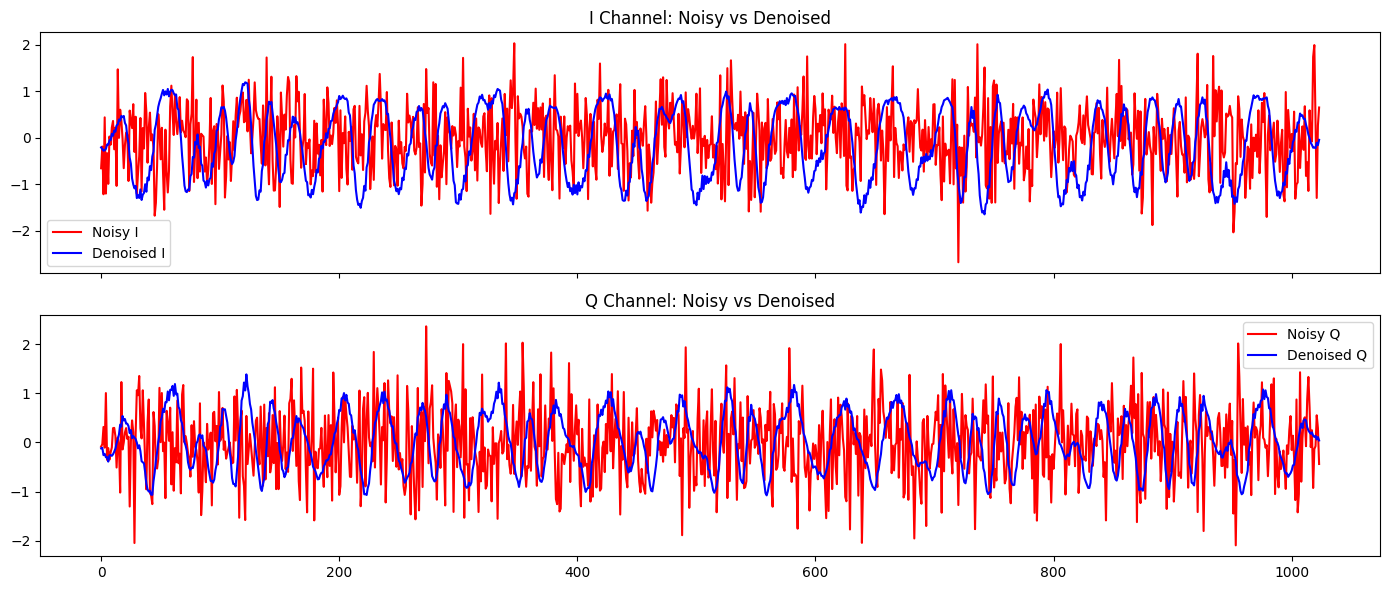

In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---- Random sample ----
idx = np.random.randint(0, len(X_noisy))
noisy_signal = X_noisy[idx:idx+1].to(DEVICE)   # Shape: (1, 1024, 2)
clean_signal = X_clean[idx].cpu().numpy()      # Shape: (1024, 2)
label = y_label[idx:idx+1].to(DEVICE)

generator.eval()
with torch.no_grad():
    denoised = generator(noisy_signal, label).cpu().squeeze(0).numpy()  # (1024, 2)
noisy_signal_np = noisy_signal.cpu().squeeze(0).numpy()                # (1024, 2)

# ---- SNR Calculation ----
def compute_snr(clean, test):
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - test) ** 2)
    return 10 * np.log10(signal_power / (noise_power + 1e-12))

snr_i_before = compute_snr(clean_signal[:,0], noisy_signal_np[:,0])
snr_i_after = compute_snr(clean_signal[:,0], denoised[:,0])
snr_q_before = compute_snr(clean_signal[:,1], noisy_signal_np[:,1])
snr_q_after = compute_snr(clean_signal[:,1], denoised[:,1])

print(f"SNR (I) Before:  {snr_i_before:.2f} dB | After: {snr_i_after:.2f} dB")
print(f"SNR (Q) Before:  {snr_q_before:.2f} dB | After: {snr_q_after:.2f} dB")

# ---- Visualization ----
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axs[0].plot(noisy_signal_np[:, 0], color='red', label='Noisy I')
axs[0].plot(denoised[:, 0], color='blue', label='Denoised I')
axs[0].set_title("I Channel: Noisy vs Denoised")
axs[0].legend()

axs[1].plot(noisy_signal_np[:, 1], color='red', label='Noisy Q')
axs[1].plot(denoised[:, 1], color='blue', label='Denoised Q')
axs[1].set_title("Q Channel: Noisy vs Denoised")
axs[1].legend()

plt.tight_layout()
plt.show()
